<a href="https://colab.research.google.com/github/nataliepham6720/16-745_Optimal_Control/blob/main/MPC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_discrete_are
import osqp
from scipy import sparse


In [4]:
g = 9.81
m = 1.0
ell = 0.3
J = 0.2 * m * ell**2

umin = np.array([0.2 * m * g, 0.2 * m * g])
umax = np.array([0.6 * m * g, 0.6 * m * g])

h = 0.05  # time step

In [5]:
from autograd import jacobian
import autograd.numpy as anp

def quad_dynamics(x, u):
    theta = x[2]
    x_ddot = (1/m) * (u[0] + u[1]) * anp.sin(theta)
    y_ddot = (1/m) * (u[0] + u[1]) * anp.cos(theta) - g
    theta_ddot = (1/J) * (ell/2) * (u[1] - u[0])
    return anp.array([x[3], x[4], x[5], x_ddot, y_ddot, theta_ddot])

def quad_dynamics_rk4(x, u):
    f1 = quad_dynamics(x, u)
    f2 = quad_dynamics(x + 0.5 * h * f1, u)
    f3 = quad_dynamics(x + 0.5 * h * f2, u)
    f4 = quad_dynamics(x + h * f3, u)
    return x + (h / 6.0) * (f1 + 2*f2 + 2*f3 + f4)

In [6]:
x_hover = np.zeros(6)
u_hover = np.array([0.5 * m * g, 0.5 * m * g])

A = jacobian(lambda x: quad_dynamics_rk4(x, u_hover))(x_hover)
B = jacobian(lambda u: quad_dynamics_rk4(x_hover, u))(u_hover)


In [18]:
# Cost matrices
Nx, Nu, Nh = 6, 2, 20
Q = np.eye(Nx)
Qn = np.eye(Nx)
R = 0.01 * np.eye(Nu)
P = solve_discrete_are(A, B, Q, R)

# Build QP matrices
def build_dynamics_constraints(A, B, Nx, Nu, Nh):
    rows = []
    for k in range(Nh):
        # For step k:
        # Row dims: Nx
        # Columns dims: Nu*Nh + Nx*(Nh+1)

        # Control inputs part
        Bu = sparse.kron(sparse.eye(1, Nh, k), B)  # shape: Nx x (Nu*Nh)

        # State inputs: -x_{k+1} + A x_k = 0
        Axk = sparse.kron(sparse.eye(1, Nh+1, k), A)       # Nx x Nx*(Nh+1)
        Ixkp1 = sparse.kron(sparse.eye(1, Nh+1, k+1), -sparse.eye(Nx))  # Nx x Nx*(Nh+1)
        Bx = Axk + Ixkp1  # Nx x Nx*(Nh+1)

        # Combine horizontally [Bu | Bx]
        row = sparse.hstack([Bu, Bx])
        rows.append(row)

    C = sparse.vstack(rows)
    return C

C = build_dynamics_constraints(A, B, Nx, Nu, Nh)
n_dyn = C.shape[0]

# Total variable length
N = Nu*Nh + Nx*(Nh+1)

# U selects all controls u_k in first Nu*Nh vars
U = sparse.hstack([
    sparse.eye(Nu*Nh, Nu*Nh),
    sparse.csc_matrix((Nu*Nh, Nx*(Nh+1)))
], format='csc')

# Theta selects theta = x[2] in all states x_0 ... x_{Nh}
theta_selector = np.zeros((1, Nx))
theta_selector[0, 2] = 1

Theta = sparse.hstack([
    sparse.csc_matrix((Nh, Nu*Nh)),
    sparse.kron(sparse.eye(Nh), sparse.csc_matrix(theta_selector)),
    sparse.csc_matrix((Nh, Nx))  # pad for the last state x_{Nh}
], format='csc')


D = sparse.vstack([C, U, Theta], format='csc')
lb = np.hstack([np.zeros(n_dyn), np.tile(umin - u_hover, Nh), -0.2 * np.ones(Nh)])
ub = np.hstack([np.zeros(n_dyn), np.tile(umax - u_hover, Nh), 0.2 * np.ones(Nh)])


# QP cost matrix H
H = sparse.block_diag(
    [sparse.block_diag([R, Q]) for _ in range(Nh)] + [Qn]
).tocsc()
q = np.zeros(H.shape[0])

# sanity check
print("C shape:", C.shape)
print("U shape:", U.shape)
print("Theta shape:", Theta.shape)
print("D shape:", D.shape)
print("H shape:", H.shape)  # must be (166, 166)
print("q shape:", q.shape)  # must be (166,)

C shape: (120, 166)
U shape: (40, 166)
Theta shape: (20, 166)
D shape: (180, 166)
H shape: (166, 166)
q shape: (166,)


In [19]:
# MPC setup
prob = osqp.OSQP()
prob.setup(P=H, q=q, A=D, l=lb, u=ub, verbose=False, eps_abs=1e-8, eps_rel=1e-8, polish=True)


In [24]:
def mpc_controller(t, x, xref, q):
    global lb, ub, prob

    # First dynamics constraint from current state
    lb[:Nx] = -A @ x
    ub[:Nx] = -A @ x

    # Reset q vector
    q[:] = 0.0

    for j in range(Nh - 1):
        idx = Nu + j * (Nu + Nx) + Nu  # start of x block
        q[idx:idx + Nx] = -Q @ xref

    # Final terminal cost block
    final_state_start = Nu + (Nh - 1)*(Nu + Nx) + Nu
    q[final_state_start:final_state_start + Nx] = -Qn @ xref

    prob.update(q=q, l=lb, u=ub)

    result = prob.solve()
    Δu = result.x[:Nu]
    return u_hover + Δu


In [21]:
def closed_loop(x0, controller, N):
    xhist = np.zeros((len(x0), N))
    uhist = np.zeros((2, N-1))
    xhist[:, 0] = x0
    uhist[:, 0] = controller(0, x0)

    for k in range(1, N):
        u = controller(k, xhist[:, k-1])
        u = np.clip(u, umin, umax)
        uhist[:, k-1] = u
        xhist[:, k] = quad_dynamics_rk4(xhist[:, k-1], u)

    return xhist, uhist


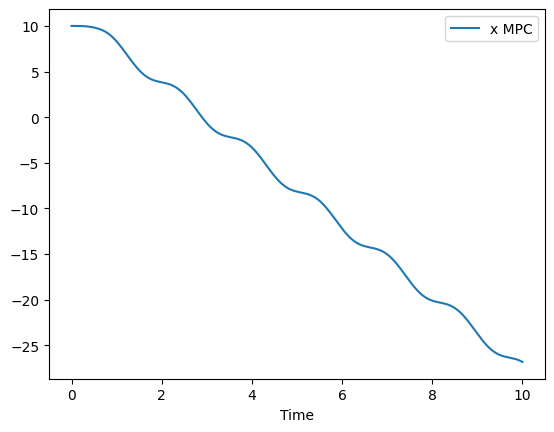

In [26]:
Tfinal = 10.0
Nt = int(Tfinal/h) + 1
thist = np.arange(0, h*Nt, h)
x_ref = np.array([0, 1, 0, 0, 0, 0])
x0 = np.array([10, 2, 0, 0, 0, 0])

# xhist1, uhist1 = closed_loop(x0, lambda t, x: lqr_controller(t, x, K, x_ref), Nt)
xhist2, uhist2 = closed_loop(x0, lambda t, x: mpc_controller(t, x, x_ref, q), Nt)

# plt.plot(thist, xhist1[0], label="x LQR")
plt.plot(thist, xhist2[0], label="x MPC")
plt.legend(); plt.xlabel("Time"); plt.show()


In [27]:
!pip install meshcat spatialmath-python

In [31]:
import meshcat
import meshcat.geometry as g
import meshcat.transformations as tf

vis = meshcat.Visualizer().open()

def set_quadrotor_mesh(vis, color=[0, 0, 0], scale=1.0, obj_file="quadrotor_scaled.obj"):
    with open(obj_file, "r") as f:
        obj_data = f.read()

    vis["quadrotor"].set_object(
        g.ObjMeshGeometry.from_string(obj_data),
        g.MeshPhongMaterial(color=color)
    )


def set_box_quadrotor(vis, color=[0, 0, 0], scale=1.0):
    vis["quadrotor"].set_object(
        g.Box([0.3 * scale, 0.05 * scale, 0.01 * scale]),
        g.MeshPhongMaterial(color=color)
    )

def visualize_planar_quadrotor(vis, xhist, h=0.05):
    anim = meshcat.animation.Animation()

    for k, x in enumerate(xhist):
        with anim.at_frame(vis, k):
            y, z = x[0], x[1]
            theta = x[2]

            T = tf.translation_matrix([0, y, z]) @ tf.rotation_matrix(-theta, [1, 0, 0])
            vis["quadrotor"].set_transform(T)

    vis.set_animation(anim)

# Choose either mesh or box
#set_quadrotor_mesh(vis, color=[0.1, 0.2, 0.6], obj_file="quadrotor_scaled.obj")
set_box_quadrotor(vis, color=[0.1, 0.2, 0.6])  # simpler

visualize_planar_quadrotor(vis, xhist2.T, h=h)

from time import sleep

visualize_planar_quadrotor(vis, xhist1.T, h=h)
print("Showing LQR trajectory...")
sleep(12)

visualize_planar_quadrotor(vis, xhist2.T, h=h)
print("Showing MPC trajectory...")

